In [1]:
import pandas as pd
from datetime import datetime, date, time, timedelta
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

In [11]:
id_to_label = {
    80676829: 'Krzysztof Bosak',
    955239446: 'Władysław Kosiniak-Kamysz',
    2280346687: 'Małgorzata Kidawa-Błońska',
    1193947151971311618: 'Szymon Hołownia',
    202086424: 'Andrzej Duda',
    466781777: 'Robert Biedroń'}

candidates_ids = [key for key in id_to_label.keys()]

# Tweets stats

In [2]:
def read_user_tweets(user_id, from_date, till_date):
    df = pd.read_csv("{}-tweets.csv".format(user_id), sep='\t', index_col=0)
    df['date'] = pd.to_datetime(df.date, format='%d/%m/%Y')
    df = df.sort_values(by='date', ascending=False)

    start = datetime.strptime(from_date, '%d/%m/%Y')
    end = datetime.strptime(till_date, '%d/%m/%Y')
 
    df = df.reset_index() \
        .set_index(['date']) \
        .loc[end : start] \
        .reset_index() \
        .set_index(['id'])
    return df

In [3]:
read_user_tweets(202086424, '10/04/2020', '14/04/2020')

,date,user_id,created_at,is_retweet,is_quote,likes,retweets,hashtags,mentions,text
id,,,,,,,,,,
1249650504155770881,2020-04-13,202086424,2020-04-13 10:47:52,0,0,2006,412,ZbrodniaKatyńska,-,Dzisiaj Dzień Pamięci Ofiar Zbrodni Katyńskiej...
1249271650471890944,2020-04-12,202086424,2020-04-12 09:42:26,0,0,7156,736,-,-,"Wszystkim Państwu składamy, razem z Agatą, naj..."
1248912411840700416,2020-04-11,202086424,2020-04-11 09:54:57,0,0,2220,249,-,-,Niestety otrzymaliśmy dziś smutną wiadomość. O...
1248613981008187392,2020-04-10,202086424,2020-04-10 14:09:05,0,0,983,121,NeverForget,"GitanasNauseda, prezydentpl",@GitanasNauseda @prezydentpl Szanowny Panie Pr...
1248592858036215808,2020-04-10,202086424,2020-04-10 12:45:09,0,0,380,45,"Smolensk, Katyn, NeverForget","GitanasNauseda, prezydentpl",@GitanasNauseda @prezydentpl Dear Mr. Presiden...
1248505235435212806,2020-04-10,202086424,2020-04-10 06:56:58,0,0,5346,919,-,-,10 lat temu Prrzydent RP Prof. Lech Kaczyński ...


### Most liked and retweeted tweets

In [4]:
def print_top_tweets(user_id, from_date, till_date):
    df = read_user_tweets(user_id, from_date, till_date)
    df = df[df['is_retweet'] == 0] # filter users own tweets
    most_retweeted = df['retweets'].nlargest(3)
    most_favourited = df['likes'].nlargest(3)
    both = pd.concat([most_retweeted, most_favourited])
    top_tweets = df[df.index.isin(both.index)]
    top_tweets.apply(lambda t: pretty_print_tweet(t), axis=1)
    
def pretty_print_tweet(tweet):
    print('\N{speech balloon} {} lajków, {} retweetów, opublikowane: {}'.format(tweet.likes, tweet.retweets, tweet.created_at))
    print(tweet['text'])
    print('\n' * 2)  

In [5]:
print_top_tweets(1193947151971311618, '10/04/2020', '14/04/2020')

💬 386 lajków, 67 retweetów, opublikowane: 2020-04-14 11:20:46
Jutro Sejm chce zajmować się ustawą o planowaniu rodziny. Wszyscy wiemy o co w tym chodzi. Jeśli naprawdę chcecie rozmawiać o rodzinie, dyskutujcie o tym jak dzisiaj pomóc polskim rodzinom, aby miały co włożyć do garnka i z czego opłacić rachunki!



💬 191 lajków, 60 retweetów, opublikowane: 2020-04-13 09:22:42
Szyjemy maseczki. Pomagamy w zakupach osobom, które nie mogą ich zrobić samodzielnie. Oddajemy krew, bo są tacy, którzy jej bardzo potrzebują. Walczymy o to, aby - dla naszego bezpieczeństwa – #PrzełoŻYĆWybory 
Wy zgłaszacie - my jesteśmy #EkipaSzymona  https://t.co/mtojgaTaUX https://t.co/fxoE75ruUO



💬 446 lajków, 57 retweetów, opublikowane: 2020-04-13 11:15:49
Pamięć o Smoleńsku nie może oznaczać schyłku pamięci o Katyniu. Hołd ofiarom Zbrodni Katyńskiej to pielęgnowanie pamięci o życiu, odwadze i mądrości 22 tysięcy Polaków, stanowiących elity II Rzeczypospolitej, zamordowanych z zimną krwią przez sowieckich zbro

### Hashtags and mentions plots

In [6]:
import random
stopwords = {"https", 'to', 'nie', 'od', 'ale', 'do', 'się', 'są', 'tego', 'dla', 'ma', 'tym', 'za', 
            'na', 'tylko', 'że', 'co', 'tak', 'ich', 'to', 'ani', 'nad', 'jest', 'przed', 'już', 'jeśli',
            'bez', 'po', 'którzy', 'temu', 'by', 'pod', 'ze', 'niż', 'które', 'przez', 'czy', 'gdzie', 'gdy',
            'żeby', 'jak', 'który', 'tych', 'tej', 'jako', 'którym', 'być', 'bo', 'ta', 'takiego', 'jej', 'te',
            'również', 'zamiast', 'je', 'aby', 'on'}

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40,
        scale=6,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    
def show_plot_bar(labels, values, size=0.3, color='lightsteelblue'):
    plt.rc('ytick', labelsize=13)
    fig = plt.figure(figsize=(10, len(labels)*size))
    ax = fig.add_axes([0,0,1,1])
    ax.invert_yaxis()
    ax.barh(labels, values, color=color)
    plt.show()

In [7]:
def plot_words_cloud(user_id, from_date, till_date):
    df = read_user_tweets(user_id, from_date, till_date)
    texts = " ".join(df['text'].tolist())
    show_wordcloud(texts)
    
def plot_hashtags(user_id, from_date, till_date):
    df = read_user_tweets(user_id, from_date, till_date)
    hashtags = []
    for elt in df['hashtags'].dropna().tolist():
        elts = elt.split(', ')
        hashtags = hashtags + elts
    hashtags = list(filter(lambda x: x is not "-", hashtags))
    if not hashtags:
        print("Kandydat nie użył żadnego hashtagu w tym okresie")
    else:
        labels, values = map(list, zip(*Counter(hashtags).most_common(50)))
        show_plot_bar(labels, values, color='lightblue')
        show_wordcloud(" ".join(hashtags))


def plot_mentions(user_id, from_date, till_date):
    df = read_user_tweets(user_id, from_date, till_date)
    mentions = []
    for elt in df['mentions'].dropna().tolist():
        elts = elt.split(', ')
        mentions = mentions + elts
    mentions = list(filter(lambda x: x is not "-", mentions))
    if not mentions:
        print("Kandydat nie oznaczał nikogo w tweetach w tym okresie")
    else:
        labels, values = map(list, zip(*Counter(mentions).most_common(50)))
        show_plot_bar(labels, values)

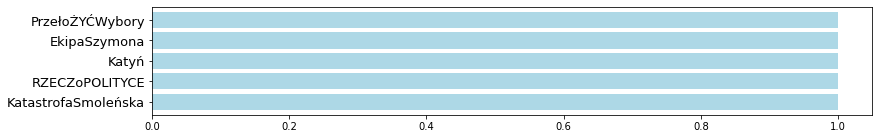

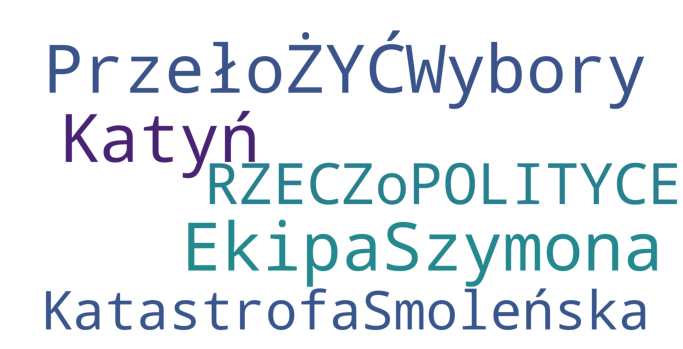

In [8]:
plot_hashtags(1193947151971311618, '10/04/2020', '14/04/2020')

# Candidates summary

In [9]:
stats_file = 'daily-stats.csv'

def read_stats():
    df = pd.read_csv(stats_file, sep='\t')
    df['date'] = pd.to_datetime(df.date, format='%d/%m/%Y')
    df = df.sort_values(by='date', ascending=False)
    df['date'] = df['date'].apply(lambda x: x.strftime('%d/%m/%Y'))
    return df

def get_summary_from_period(from_date, till_date):

    # daily stats
    data = read_stats()
    stats_df = data.set_index(['profile', 'date'])
    diffs = stats_df.groupby(['profile']) \
            .apply(lambda x: x.diff(periods=-1)) \
            .reset_index() \
            .set_index(['profile']) \
            .groupby(['profile']) \
            .apply(lambda x: x.set_index('date').loc[till_date : from_date])

    col = ['total followers', 'new followers', '% followers growth']
    series_list_stats = [pd.Series([
        int(stats_df.loc[(name, till_date)]['followers']),
        int(group['followers'].sum()),
        int(group['followers'].sum() / stats_df.loc[(name, from_date)]['followers'] * 100)
    ], index=col, name=name) for name, group in diffs.groupby(['profile'])]
    
    summary_stats = pd.DataFrame(series_list_stats)
    
    # tweets
    tweets_df = pd.concat([read_user_tweets(user_id, from_date, till_date) for user_id in candidates_ids])
    
    col = ['tweets', 'retweets %', 
           'avg. likes', 'avg. retweets',
           'total likes', 'total retweets',
           'most liked', 'most retweeted'
          ]
    series_list_tweets = [pd.Series([
        len(group.index),
        int((group['is_retweet'].sum() / len(group.index) * 100)),
        
        int(group[group['is_retweet'] == 0]['likes'].mean()),
        int(group[group['is_retweet'] == 0]['retweets'].mean()),
        
        group['likes'].sum(),
        group[group['is_retweet'] == 0]['retweets'].sum(),
        
        group['likes'].max(),
        group[group['is_retweet'] == 0]['retweets'].max(),

    ], index=col, name=name) for name, group in tweets_df.groupby(['user_id'])]

    summary_tweets = pd.DataFrame(series_list_tweets)
    summary = pd.concat([summary_stats, summary_tweets], axis=1)
    summary.index.name = 'profile'
    return summary.reset_index().replace({"profile": id_to_label}).set_index('profile')

In [12]:
df = get_summary_from_period('10/04/2020', '14/04/2020')
df

,total followers,new followers,% followers growth,tweets,retweets %,avg. likes,avg. retweets,total likes,total retweets,most liked,most retweeted
profile,,,,,,,,,,,
Krzysztof Bosak,171835,1003,0,47,46,337,43,8426,1084,2514,340
Andrzej Duda,1115799,3159,0,6,0,3015,413,18091,2482,7156,919
Robert Biedroń,221510,1374,0,34,29,605,112,14522,2707,4857,1218
Władysław Kosiniak-Kamysz,105807,1598,1,3,0,518,44,1554,134,1178,47
Małgorzata Kidawa-Błońska,100916,1752,1,7,14,1071,189,6426,1136,3536,511
Szymon Hołownia,32629,1581,5,22,27,204,32,3275,520,571,71
